In [1]:
import numpy as np
import utils.read_data as read
import utils.features as features
from utils.handlers.constants import UNK

from sklearn.model_selection import GroupKFold, train_test_split

from sklearn.metrics import roc_auc_score
import shap

from tqdm.auto import tqdm

from utils.models import Embeddings, CatBoost, Stack

SEED = 42

In [2]:
members = read.members("data/members.csv")

songs = read.songs("data/songs.csv")
song_extra_info = read.extra_info("data/song_extra_info.csv")

songs = songs.merge(song_extra_info, on="song_id", how="left")

train = read.train("data/train.csv")

In [3]:
members = features.member(members)
songs = features.song(songs)

In [4]:
data = train.merge(members, on="msno", how="left").merge(songs, on="song_id", how="left").astype({"msno": "category", "song_id": "category"})

data.source_screen_name = data.source_screen_name.cat.add_categories(UNK).fillna(UNK)
data.source_system_tab = data.source_system_tab.cat.add_categories(UNK).fillna(UNK)
data.source_type = data.source_type.cat.add_categories(UNK).fillna(UNK)

data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,composer,lyricist,language,name,artist_count,composer_count,lyricist_count,genre_count,isrc_year,isrc_country
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Dan Smith| Mark Crew,<UNK>,52.0,Good Grief,1.0,2.0,0.0,1.0,16,GB
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,<UNK>,<UNK>,52.0,Lords of Cardboard,1.0,0.0,0.0,1.0,99,US
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,Hip Hop Is Dead(Album Version (Edited)),1.0,1.0,0.0,1.0,6,US
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,Kwadwo Donkoh,<UNK>,-1.0,Disco Africa,1.0,1.0,0.0,1.0,10,GB
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Brett Young| Kelly Archer| Justin Ebach,<UNK>,52.0,Sleep Without You,1.0,3.0,0.0,1.0,16,QM


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 29 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   msno                     category
 1   song_id                  category
 2   source_system_tab        category
 3   source_screen_name       category
 4   source_type              category
 5   target                   int32   
 6   city                     category
 7   bd                       category
 8   gender                   category
 9   registered_via           category
 10  registration_init_year   category
 11  registration_init_month  category
 12  registration_init_day    category
 13  expiration_year          category
 14  expiration_month         category
 15  expiration_day           category
 16  song_length              float64 
 17  genre_ids                category
 18  artist_name              category
 19  composer                 category
 20  lyricist                

In [6]:
na_mask = data.isna().any(1)
data = data[~na_mask]

In [7]:
data.sort_values("msno", kind="stable", inplace=True)
data = data.iloc[:10000]

In [8]:
def DCG(s, r):
    idx = np.argsort(-s)
    return np.sum(r[idx] / np.log2(1 + np.arange(1, len(s) + 1)))

def IDCG(s, r):
    return np.sum(-np.sort(-r) / np.log2(1 + np.arange(1, len(s) + 1)))

def NDCG(q, s, r):
    q_labs = np.unique(q)
    
    ndcgs = []
    for q_lab in q_labs:
        msk = q_lab == q
        
        q_dcg = DCG(s[msk], r[msk])
        q_idcg = IDCG(s[msk], r[msk])
        
        if q_idcg > 0:
            ndcgs.append(q_dcg / q_idcg)
            
    return np.mean(ndcgs)

def AUC(q, s, r):
    q_labs = np.unique(q)
    
    aucs = []
    for q_lab in q_labs:
        msk = q_lab == q
        try:
            auc = roc_auc_score(r[msk], s[msk])
            aucs.append(auc)
        except ValueError:
            pass
        
    return np.mean(aucs)

In [9]:
idxs_train, idxs_test = train_test_split(np.random.permutation(len(data)), test_size=1000)
idxs_train = sorted(idxs_train)
idxs_test = sorted(idxs_test)

data_train = data.iloc[idxs_train]
data_test = data.iloc[idxs_test]

# extremely long
# columns_to_filter = ["msno", "song_id"]
# msk = np.isin(data_train[columns_to_filter], data_test[columns_to_filter])
# data_test = data_test[~np.all(msk, axis=1)]

In [10]:
model = Embeddings(100)

model.fit(data_train)

s = model.predict(data_test)
q = data_test.msno.cat.codes.to_numpy()
r = data_test.target.to_numpy()

print(f"NDCG = {NDCG(q, s, r)} | ROC AUC = {AUC(q, s, r)}")

Fitting items...
Fitting users...


100%|██████████| 30755/30755 [00:00<00:00, 50296.30it/s]

NDCG = 0.7892501730076193 | ROC AUC = 0.5111555973172256


# Stacked models

In [11]:
data_train = data_train.groupby("msno").head(1023).reset_index(drop=True)
data_test = data_test.groupby("msno").head(1023).reset_index(drop=True)

q = data_test.msno.cat.codes.to_numpy()
r = data_test.target.to_numpy()

In [12]:
emb_model = Embeddings(100)
catboost_model = CatBoost(150)
model = Stack(catboost_model, emb_model)

In [13]:
model.fit(data_train)

s = model.predict(data_test)

print(f"NDCG = {NDCG(q, s, r)} | ROC AUC = {AUC(q, s, r)}")

Fitting items...
Fitting users...


100%|██████████| 30755/30755 [00:00<00:00, 48025.16it/s]


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 7.11ms	remaining: 1.06s
10:	total: 69.4ms	remaining: 877ms
20:	total: 125ms	remaining: 768ms
30:	total: 180ms	remaining: 689ms
40:	total: 234ms	remaining: 622ms
50:	total: 294ms	remaining: 571ms
60:	total: 348ms	remaining: 508ms
70:	total: 399ms	remaining: 444ms
80:	total: 450ms	remaining: 383ms
90:	total: 505ms	remaining: 327ms
100:	total: 558ms	remaining: 271ms
110:	total: 611ms	remaining: 215ms
120:	total: 665ms	remaining: 159ms
130:	total: 743ms	remaining: 108ms
140:	total: 809ms	remaining: 51.6ms
149:	total: 858ms	remaining: 0us
NDCG = 0.7952508433368649 | ROC AUC = 0.5736910074135902


In [14]:
model.fit(data_train)

scores_train = model.get_emb_score(data_train)
scores_test = model.get_emb_score(data_test)

data_train["scores"] = scores_train
data_test["scores"] = scores_test

Fitting items...
Fitting users...


100%|██████████| 30755/30755 [00:00<00:00, 49021.11it/s]


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 6.62ms	remaining: 987ms
10:	total: 63.8ms	remaining: 806ms


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


20:	total: 128ms	remaining: 784ms
30:	total: 194ms	remaining: 745ms
40:	total: 250ms	remaining: 664ms
50:	total: 300ms	remaining: 583ms
60:	total: 353ms	remaining: 515ms
70:	total: 411ms	remaining: 457ms
80:	total: 465ms	remaining: 396ms
90:	total: 517ms	remaining: 335ms
100:	total: 570ms	remaining: 277ms
110:	total: 628ms	remaining: 221ms
120:	total: 686ms	remaining: 164ms
130:	total: 738ms	remaining: 107ms
140:	total: 796ms	remaining: 50.8ms
149:	total: 848ms	remaining: 0us


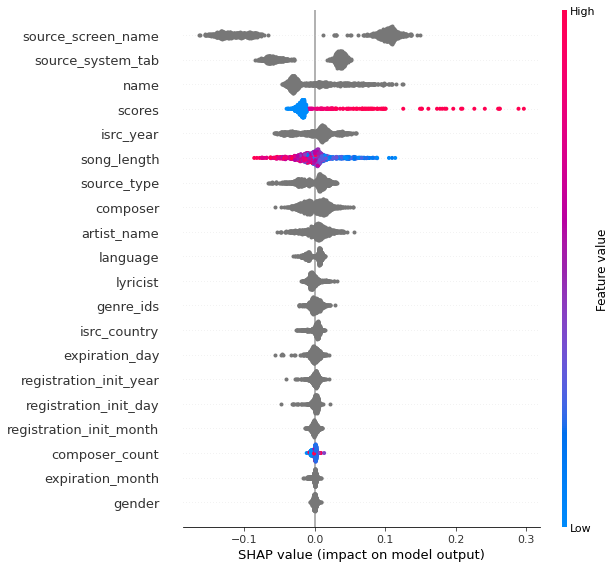

In [15]:

scores = model.get_emb_score(data_test)
data_test["scores"] = scores
X_test = data_test.drop(columns=["target", "song_id", "msno"], axis=1)

se = shap.TreeExplainer(model.catboost.model, feature_perturbation="tree_path_dependent")
shap_vals = se.shap_values(X_test)
shap.summary_plot(shap_vals, X_test)